In [1]:
%matplotlib inline
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#plt.rcParams['figure.dpi']= 300  #resolution

from collections import defaultdict

In [2]:
def draw_list(ts_list, attribute, ts_number=1000, time = None , formatter = None):
    if ts_number >= len(ts_list): ts_number = len(ts_list)-1
    fig = plt.figure()
    ax = fig.subplots()
    for ts in ts_list[:ts_number]:
        if time == None: index = list(ts.index.values)
        else: index= ts[time]
        ax.plot(index, ts[attribute])
    ax.set_ylabel(attribute)
    if formatter !=None:
        date_form = DateFormatter(formatter)
        ax.xaxis.set_major_formatter(date_form)
    plt.show()

# Data Preparation

In [3]:
time_col = 'date'

attributes = ['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']


df=pd.read_csv(r'/Users/Cava/Desktop/University/Data Science & Business Informatics/Data Mining/Advanced Topics and Applications/Project/data/datatraining.txt')
df[time_col] =  pd.to_datetime(df[time_col], format = '%Y-%m-%d %H:%M:%S')
df['Weekday']=df[time_col].apply(lambda x:x.weekday())

mon1=df[df['Weekday']==0][attributes].copy()
tue1=df[df['Weekday']==1][attributes].copy()  #missing part of the day
wed1=df[df['Weekday']==2][attributes].copy() #incompleted too
thu1=df[df['Weekday']==3][attributes].copy()
fri1=df[df['Weekday']==4][attributes].copy()
sat1=df[df['Weekday']==5][attributes].copy()
sun1=df[df['Weekday']==6][attributes].copy()
    
weekdays1 = [thu1,fri1,sat1,sun1,mon1] #I dont want incompleted days, so wednesday and tuesday are excluded



df=pd.read_csv(r'/Users/Cava/Desktop/University/Data Science & Business Informatics/Data Mining/Advanced Topics and Applications/Project/data/datatest2.txt')
df[time_col] =  pd.to_datetime(df[time_col], format = '%Y-%m-%d %H:%M:%S')
df['Weekday']=df[time_col].apply(lambda x:x.weekday())
                                 
mon2=df[df['Weekday']==0][attributes].copy()
tue2=df[df['Weekday']==1][attributes].copy()  #missing part of the day
wed2=df[df['Weekday']==2][attributes].copy() #incompleted too
thu2=df[df['Weekday']==3][attributes].copy()
fri2=df[df['Weekday']==4][attributes].copy()
sat2=df[df['Weekday']==5][attributes].copy()
sun2=df[df['Weekday']==6][attributes].copy()
    
weekdays2 = [thu2,fri2,sat2,sun2,mon2] #I dont want incompleted days, so wednesday and tuesday are excluded


## week list

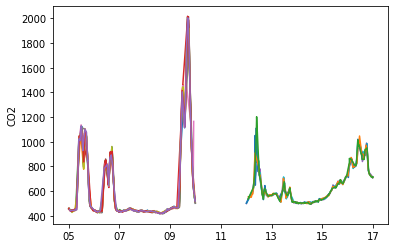

In [4]:
week_size = 144
week_list = []
labels = []

week1 = pd.DataFrame()
for day in weekdays1:
    day.sort_values(time_col, inplace=True)#first of all: order
    week1 = week1.append(day, ignore_index=True )    ##a week
    
    
week1_list = []
tmp = week1.copy() 
while(len(tmp)>=week_size):
    ts = tmp.sample(week_size)
    ts.sort_values(time_col, inplace=True)
    week1_list.append(ts)
    week_list.append(ts)
    tmp.drop(ts.index, axis=0, inplace=True) #remove the sample just extract

    
week2 = pd.DataFrame()
for day in weekdays2:    
    day.sort_values(time_col, inplace=True)#first of all: order
    week2 = week2.append(day, ignore_index=True)    ##a week
    
week2_list = []
tmp = week2.copy() 
while(len(tmp)>=week_size):
    ts = tmp.sample(week_size)
    ts.sort_values(time_col, inplace=True)
    week2_list.append(ts)
    week_list.append(ts)
    tmp.drop(ts.index, axis=0, inplace=True) #remove the sample just extract

    
random.shuffle(week_list)
draw_list(week_list, 'CO2', 15, time = time_col ,formatter = '%d')

In [5]:
ts_list = []
for temp in week_list:
    ts = temp['Temperature'].copy()
    ts_list.append((ts-ts.mean())/ts.std())

ts_array = []
ts_size = len(week_list[1])
for ts in ts_list:
    ts_array.append(np.array(ts).reshape(ts_size,))
    
X = np.array(ts_array)
week1o2 = lambda ts : 0 if ts['date'][ts.index[0]].day == 12 else 1
labels = [week1o2(ts) for ts in week_list]
y = labels.copy()
X.shape

(100, 144)

# Data Normalization

In [6]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score 

Using Theano backend.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
scaler = TimeSeriesScalerMinMax()
X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

# Data Partitioning

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Shaplet Classifier

In [10]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 70
ts_sz 144
n_classes 2
shapelet_sizes {14: 3}


In [11]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

In [12]:
shp_clf.fit(X_train, y_train)

Epoch 1/200
70/70 [==============================] - 0s 86us/step - loss: 0.7181 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6933
Epoch 2/200
70/70 [==============================] - 0s 48us/step - loss: 0.7181 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6933
Epoch 3/200
70/70 [==============================] - 0s 48us/step - loss: 0.7181 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6933
Epoch 4/200
70/70 [==============================] - 0s 49us/step - loss: 0.7181 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6933
Epoch 5/200
70/70 [==============================] - 0s 41us/step - loss: 0.7180 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6933
Epoch 6/200
70/70 [==============================] - 0s 42us/step - loss: 0.7180 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6933
Epoch 7/200
70/70 [==============================] - 0s 47us/step - loss: 0.7180 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6933
Epoch 8/200
70/70 [======================

Epoch 61/200
70/70 [==============================] - 0s 61us/step - loss: 0.7175 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6933
Epoch 62/200
70/70 [==============================] - 0s 67us/step - loss: 0.7175 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6933
Epoch 63/200
70/70 [==============================] - 0s 49us/step - loss: 0.7175 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 64/200
70/70 [==============================] - 0s 46us/step - loss: 0.7175 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 65/200
70/70 [==============================] - 0s 49us/step - loss: 0.7174 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 66/200
70/70 [==============================] - 0s 59us/step - loss: 0.7174 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 67/200
70/70 [==============================] - 0s 64us/step - loss: 0.7174 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 68/200
70/70 [==============

Epoch 121/200
70/70 [==============================] - 0s 50us/step - loss: 0.7169 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 122/200
70/70 [==============================] - 0s 65us/step - loss: 0.7169 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 123/200
70/70 [==============================] - 0s 57us/step - loss: 0.7169 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 124/200
70/70 [==============================] - 0s 74us/step - loss: 0.7169 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 125/200
70/70 [==============================] - 0s 52us/step - loss: 0.7169 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 126/200
70/70 [==============================] - 0s 43us/step - loss: 0.7169 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 127/200
70/70 [==============================] - 0s 52us/step - loss: 0.7168 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6932
Epoch 128/200
70/70 [======

Epoch 180/200
70/70 [==============================] - 0s 82us/step - loss: 0.7163 - binary_accuracy: 0.4714 - binary_crossentropy: 0.6932
Epoch 181/200
70/70 [==============================] - 0s 77us/step - loss: 0.7163 - binary_accuracy: 0.4714 - binary_crossentropy: 0.6932
Epoch 182/200
70/70 [==============================] - 0s 72us/step - loss: 0.7163 - binary_accuracy: 0.4714 - binary_crossentropy: 0.6932
Epoch 183/200
70/70 [==============================] - 0s 49us/step - loss: 0.7163 - binary_accuracy: 0.4714 - binary_crossentropy: 0.6932
Epoch 184/200
70/70 [==============================] - 0s 48us/step - loss: 0.7163 - binary_accuracy: 0.4714 - binary_crossentropy: 0.6932
Epoch 185/200
70/70 [==============================] - 0s 53us/step - loss: 0.7163 - binary_accuracy: 0.4714 - binary_crossentropy: 0.6932
Epoch 186/200
70/70 [==============================] - 0s 65us/step - loss: 0.7163 - binary_accuracy: 0.4714 - binary_crossentropy: 0.6932
Epoch 187/200
70/70 [======

ShapeletModel(max_iter=200, n_shapelets_per_size={14: 3}, verbose=1,
              weight_regularizer=0.01)

In [13]:
y_pred = shp_clf.predict(X_test)

30/30 [==============================] - 0s 29us/step


In [14]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5666666666666667
F1-score [0.23529412 0.69767442]
              precision    recall  f1-score   support

           0       1.00      0.13      0.24        15
           1       0.54      1.00      0.70        15

    accuracy                           0.57        30
   macro avg       0.77      0.57      0.47        30
weighted avg       0.77      0.57      0.47        30



# Shaplet-distances-based Classifier

In [15]:
X_train2 = shp_clf.transform(X_train)

70/70 [==============================] - 0s 18us/step


In [16]:
X_train2.shape

(70, 3)

In [17]:
X_train2

array([[0.00961492, 0.00904149, 0.010555  ],
       [0.0074772 , 0.00729009, 0.00863088],
       [0.00542986, 0.00502806, 0.00601648],
       [0.00373622, 0.00282966, 0.00368353],
       [0.00295409, 0.00242596, 0.00334106],
       [0.00517565, 0.00418332, 0.00541746],
       [0.00945592, 0.00922877, 0.00997508],
       [0.00295299, 0.0028081 , 0.00296651],
       [0.00817058, 0.00736873, 0.00860783],
       [0.00711666, 0.00610721, 0.00778168],
       [0.00434842, 0.00424016, 0.00500733],
       [0.00541822, 0.00542023, 0.00528584],
       [0.00596032, 0.00628975, 0.0074315 ],
       [0.00169024, 0.00145656, 0.00216301],
       [0.0058855 , 0.00583454, 0.00662166],
       [0.00444156, 0.00397027, 0.00532927],
       [0.00588287, 0.00530139, 0.00595906],
       [0.00539718, 0.00518115, 0.00605365],
       [0.00529195, 0.004936  , 0.00535252],
       [0.00455882, 0.00464422, 0.005337  ],
       [0.00526366, 0.00511295, 0.00583952],
       [0.00269345, 0.00244951, 0.00314537],
       [0.

In [18]:
X_test2 = shp_clf.transform(X_test)

30/30 [==============================] - 0s 24us/step


In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train2, y_train)

KNeighborsClassifier()

In [21]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5666666666666667
F1-score [0.48       0.62857143]
              precision    recall  f1-score   support

           0       0.60      0.40      0.48        15
           1       0.55      0.73      0.63        15

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.55        30
weighted avg       0.57      0.57      0.55        30



In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5666666666666667
F1-score [0.55172414 0.58064516]
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.56      0.60      0.58        15

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.57        30
weighted avg       0.57      0.57      0.57        30



# Feature-based Classifier

In [24]:
import scipy.stats as stats

In [25]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [26]:
X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])

In [27]:
X_train3.shape

(70, 13)

In [28]:
X_train3

array([[ 0.43927152,  0.27209024,  0.0740331 ,  0.40488432,  0.10025707,
         0.19730077,  0.40488432,  0.65070694,  0.81748072,  0.45340617,
         1.61443319,  0.22065247, -1.10200899],
       [ 0.31167953,  0.22444126,  0.05037388,  0.24444444,  0.10255556,
         0.13333333,  0.24444444,  0.44444444,  0.63555556,  0.31111111,
         1.38869084,  1.14018974,  0.74900105],
       [ 0.29156586,  0.23564912,  0.05553051,  0.20986359,  0.06086044,
         0.13641133,  0.20986359,  0.40490556,  0.6239944 ,  0.26849423,
         1.23728816,  1.36724864,  1.20918862],
       [ 0.36421441,  0.2583849 ,  0.06676276,  0.3225    ,  0.05708333,
         0.13125   ,  0.3225    ,  0.56828125,  0.75      ,  0.43703125,
         1.40958084,  0.4385618 , -0.94833788],
       [ 0.38993345,  0.27252317,  0.07426888,  0.35      ,  0.061875  ,
         0.146875  ,  0.35      ,  0.579375  ,  0.7975    ,  0.4325    ,
         1.43082679,  0.45976979, -0.8712124 ],
       [ 0.37629406,  0.266714

In [29]:
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

In [30]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



# Time Series Classifier

In [31]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9666666666666667
F1-score [0.96551724 0.96774194]
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.94      1.00      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [32]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [33]:
from pyts.classification import KNeighborsClassifier

In [34]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



# CNN Classifier

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization

In [36]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [37]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  144
N. LABELS:  2


In [38]:
cnn = build_simple_cnn(n_timesteps, n_outputs)

In [39]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 137, 16)           144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 137, 16)           64        
_________________________________________________________________
activation_1 (Activation)    (None, 137, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 137, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 133, 32)           2592      
_________________________________________________________________
batch_normalization_2 (Batch (None, 133, 32)           128       
_________________________________________________________________
activation_2 (Activation)    (None, 133, 32)          

In [40]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [41]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

In [42]:
history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Train on 56 samples, validate on 14 samples
Epoch 1/5
56/56 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.5000 - val_loss: 0.6904 - val_accuracy: 0.5000


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Epoch 2/5
56/56 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.7143 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 3/5
56/56 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6786 - val_loss: 0.6871 - val_accuracy: 0.5000
Epoch 4/5
56/56 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.65 - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6429 - val_loss: 0.6863 - val_accuracy: 0.5000
Epoch 5/5
56/56 [==============================] - 0s 3ms/step - loss: 0.5828 - accuracy: 0.7143 - val_loss: 0.6867 - val_accuracy: 0.5000


In [43]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5
F1-score [0.         0.66666667]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
cnn.evaluate(X_test_cnn, y_test)

30/30 [==============================] - 0s 1ms/step


[0.6870226263999939, 0.5]

# LSTM Classifier

In [45]:
from keras.layers import LSTM

In [46]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [47]:
lstm = build_lstm(n_timesteps, n_outputs)

In [48]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 280,770
Trainable params: 280,770
Non-trainable params: 0
_________________________________________________________________


In [49]:
history_lstm = cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

Train on 56 samples, validate on 14 samples
Epoch 1/10
56/56 [==============================] - 0s 3ms/step - loss: 0.5908 - accuracy: 0.7143 - val_loss: 0.6860 - val_accuracy: 0.5714


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Epoch 2/10
56/56 [==============================] - 0s 3ms/step - loss: 0.5274 - accuracy: 0.8214 - val_loss: 0.6863 - val_accuracy: 0.5714
Epoch 3/10
56/56 [==============================] - 0s 3ms/step - loss: 0.5356 - accuracy: 0.8036 - val_loss: 0.6880 - val_accuracy: 0.6429
Epoch 4/10
56/56 [==============================] - 0s 3ms/step - loss: 0.5103 - accuracy: 0.7679 - val_loss: 0.6885 - val_accuracy: 0.7143
Epoch 5/10
56/56 [==============================] - 0s 3ms/step - loss: 0.5028 - accuracy: 0.7500 - val_loss: 0.6863 - val_accuracy: 0.6429
Epoch 6/10
56/56 [==============================] - 0s 3ms/step - loss: 0.4911 - accuracy: 0.8036 - val_loss: 0.6880 - val_accuracy: 0.5714
Epoch 7/10
56/56 [==============================] - 0s 3ms/step - loss: 0.3830 - accuracy: 0.9643 - val_loss: 0.6882 - val_accuracy: 0.5714
Epoch 8/10
56/56 [==============================] - 0s 3ms/step - loss: 0.4518 - accuracy: 0.7857 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 9/10
56/56 [==

In [50]:
y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5
F1-score [0.66666667 0.        ]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        15
           1       0.00      0.00      0.00        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
lstm.evaluate(X_test_cnn, y_test)

30/30 [==============================] - 0s 3ms/step


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


[0.6950158476829529, 0.5]

# Multivariate Time Series Classifiers

In [52]:
from pyts.datasets import load_basic_motions

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [53]:
from sklearn import preprocessing

ts_list = []
for temp in week_list:
    ts = temp[['Temperature','Humidity','CO2','Light','HumidityRatio']].copy()
    ts_list.append(ts)

ts_array = []
ts_size = len(week_list[1])
for ts in ts_list:
    ts_array.append(np.array(ts))
    
X = np.array(ts_array)

X.shape

(100, 144, 5)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [55]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
print(X_train.shape, X_test.shape)

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

(70, 144, 5) (30, 144, 5)
[[ 0  1]
 [35 35]]
[[ 0  1]
 [15 15]]


In [57]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_train)), X_train.shape[2] 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)
print("N. FEATURES: ", n_features)

TIMESTEPS:  144
N. LABELS:  2
N. FEATURES:  5


In [58]:
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [59]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [60]:
def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True, 
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    #3
    for _ in range(2):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [61]:
lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

In [62]:
lstm2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 144, 4)            160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 144, 4)            16        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 144, 4)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 144, 4)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 144, 4)            144       
_________________________________________________________________
batch_normalization_5 (Batch (None, 144, 4)            16        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 144, 4)           

In [63]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [64]:
history_lstm2 = lstm2.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

Train on 56 samples, validate on 14 samples
Epoch 1/50
21/56 [==========>...................] - ETA: 0s - loss: 0.6935 - accuracy: 0.5714

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


56/56 [==============================] - 0s 7ms/step - loss: 0.7151 - accuracy: 0.5536 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
56/56 [==============================] - 0s 8ms/step - loss: 0.5400 - accuracy: 0.7679 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/50
56/56 [==============================] - 1s 9ms/step - loss: 0.4526 - accuracy: 0.7857 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
56/56 [==============================] - 1s 10ms/step - loss: 0.4107 - accuracy: 0.8929 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/50
56/56 [==============================] - 1s 10ms/step - loss: 0.3206 - accuracy: 0.9643 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 6/50
56/56 [==============================] - 1s 9ms/step - loss: 0.2992 - accuracy: 0.9107 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 7/50
56/56 [==============================] - 1s 10ms/step - loss: 0.4015 - accuracy: 0.8929 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 8/50
56/56 [==========

In [65]:
y_pred = np.argmax(lstm2.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5
F1-score [0.         0.66666667]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
X_train_cnn.shape

(56, 144, 5)

In [67]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], X_val_cnn.shape[2], 1)
X_test_cnn2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train_cnn2.shape

(56, 144, 5, 1)

In [68]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 3
    
    ks2_first = 4
    ks2_second = 4
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [69]:
cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

In [70]:
cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 144, 5, 3)         30        
_________________________________________________________________
batch_normalization_12 (Batc (None, 144, 5, 3)         12        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 144, 5, 3)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 144, 5, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 5, 4)         196       
_________________________________________________________________
batch_normalization_13 (Batc (None, 144, 5, 4)         16        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 144, 5, 4)        

In [71]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [72]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn2, y_val_cnn)).history

Train on 56 samples, validate on 14 samples
Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8828 - accuracy: 0.4821 - val_loss: 0.6932 - val_accuracy: 0.5000


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8190 - accuracy: 0.5357 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.7175 - accuracy: 0.5000 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.5365 - accuracy: 0.7857 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4499 - accuracy: 0.8036 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4846 - accuracy: 0.7857 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3667 - accuracy: 0.8571 - val_loss: 0.7033 - val_accuracy: 0.5000
Epoch 8/50
56/56 [==============================] - 0s 2ms/step - loss: 0.4227 - accuracy: 0.7679 - val_loss: 0.7064 - val_accuracy: 0.5000
Epoch 9/50
56/56 [==

In [73]:
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5
F1-score [0.         0.66666667]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
def build_cnn3(n_timesteps, n_outputs, n_features):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [75]:
cnn3 = build_cnn3(n_timesteps, n_outputs, n_features)

In [76]:
cnn3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 137, 16)           656       
_________________________________________________________________
batch_normalization_23 (Batc (None, 137, 16)           64        
_________________________________________________________________
activation_4 (Activation)    (None, 137, 16)           0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 137, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 133, 32)           2592      
_________________________________________________________________
batch_normalization_24 (Batc (None, 133, 32)           128       
_________________________________________________________________
activation_5 (Activation)    (None, 133, 32)          

In [77]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [78]:
history_cnn3 = cnn3.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Train on 56 samples, validate on 14 samples
Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 0.6809 - accuracy: 0.5536 - val_loss: 0.6821 - val_accuracy: 0.5000
Epoch 2/50
42/56 [=====================>........] - ETA: 0s - loss: 0.5483 - accuracy: 0.8095

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


56/56 [==============================] - 0s 2ms/step - loss: 0.5410 - accuracy: 0.8571 - val_loss: 0.6745 - val_accuracy: 0.5714
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3385 - accuracy: 1.0000 - val_loss: 0.6649 - val_accuracy: 0.9286
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2047 - accuracy: 1.0000 - val_loss: 0.6519 - val_accuracy: 1.0000
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.2705 - accuracy: 0.9286 - val_loss: 0.6413 - val_accuracy: 1.0000
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1130 - accuracy: 1.0000 - val_loss: 0.6375 - val_accuracy: 1.0000
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0880 - accuracy: 1.0000 - val_loss: 0.6364 - val_accuracy: 0.7857
Epoch 8/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 1.0000 - val_loss: 0.6429 - val_accuracy: 0.7857
Epoch 9/50
56/56 [=============

In [79]:
y_pred = np.argmax(cnn3.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://pyts.readthedocs.io/en/stable/generated/pyts.multivariate.classification.MultivariateClassifier.html#pyts.multivariate.classification.MultivariateClassifier